In [1]:
import torch
torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from mlxtend.plotting import plot_confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
import random

In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [18]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
class AugmentedFERDataset(FERDataset):
    def __init__(self, dataframe, classes_to_augment, transform=None, augment_transform=None, target_count=None):
        super().__init__(dataframe, transform)
        self.augment_transform = augment_transform
        self.augmented_data = []  # Simpan semua hasil augmentasi
        
        for class_to_augment in classes_to_augment:
            self.augment_class(class_to_augment, target_count)

    def augment_class(self, class_to_augment, target_count):
        # Filter sampel minoritas
        minority_indices = np.where(self.labels == class_to_augment)[0]
        minority_samples = self.pixels[minority_indices]

        # Pastikan ada data untuk augmentasi
        if len(minority_samples) == 0:
            print(f"Tidak ada sampel untuk kelas {class_to_augment}, lewati augmentasi.")
            return

        # Target augmentasi, minimal dua kali data asli jika target_count tidak diberikan
        target_count = target_count if target_count else len(minority_samples) * 2
        augmented_images = self.augment_minority_data(minority_samples, target_count)

        # Tambahkan hasil augmentasi ke data
        self.augmented_data.extend([(img, class_to_augment) for img in augmented_images])

    def augment_minority_data(self, minority_samples, target_count):
        augmented_images = []
        while len(augmented_images) < target_count - len(minority_samples):
            idx = np.random.choice(len(minority_samples))
            image = Image.fromarray(minority_samples[idx].squeeze().astype('uint8'), mode='L')
            augmented_image = self.augment_transform(image)
            augmented_images.append(augmented_image)
        return augmented_images

    def __getitem__(self, idx):
        # Jika idx di luar data asli, ambil dari augmented_data
        if idx < len(self.pixels):
            image, label = super().__getitem__(idx)
        else:
            idx -= len(self.pixels)
            image, label = self.augmented_data[idx]
        return image, label

    def __len__(self):
        return len(self.pixels) + len(self.augmented_data)

In [12]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])           
print(f"transforms: {manual_transforms}")

transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [ ]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by +/- 10 degrees
    transforms.RandomResizedCrop(224), # Randomly crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    # transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
data = pd.read_csv('../Data/fer2013_clean.csv')
data.info()

In [19]:
# data_train = pd.read_csv('../Data/fer_train.csv')
data_val = pd.read_csv('../Data/fer_val.csv')
data_test = pd.read_csv('../Data/fer_test.csv')

In [ ]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

In [ ]:
# Menghitung jumlah sampel per kelas
class_counts = data_train['emotion'].value_counts()
print("Distribusi kelas:\n", class_counts)

# Menentukan jumlah kelas mayoritas
majority_class_count = class_counts.max()

# Menentukan kelas minoritas (yang membutuhkan augmentasi)
classes_to_augment = class_counts[class_counts < majority_class_count].index.tolist()

print(f"Kelas yang perlu di-augmentasi: {classes_to_augment}")

In [ ]:
train_dataset = AugmentedFERDataset(
    data_train,
    classes_to_augment=classes_to_augment,
    transform=manual_transforms,
    augment_transform=augmentations,
    target_count=majority_class_count
)
val_dataset = FERDataset(data_val, transform=manual_transforms)
test_dataset = FERDataset(data_test, transform=manual_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [13]:
train_dataset = FERDataset(data_train, transform=manual_transforms)
val_dataset = FERDataset(data_val, transform=manual_transforms)
test_dataset = FERDataset(data_test, transform=manual_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
print(f"Total data setelah augmentasi: {len(train_dataset)}")

In [ ]:
data = []
for idx in range(len(train_dataset)):
    image, label = train_dataset[idx]
    # Convert image back to a flattened string (if needed)
    image_array = np.array(image).flatten()
    image_str = ' '.join(map(str, image_array))
    data.append([image_str, label])

# Create a DataFrame
columns = ['pixels', 'emotion']
augmented_df = pd.DataFrame(data, columns=columns)

In [ ]:
augmented_df.info()

In [ ]:
augmented_df.head()

In [ ]:
augmented_df.to_csv('../Data/fer_train.csv', index=False)

In [ ]:
data_val.to_csv('../Data/fer_val.csv', index=False)

In [ ]:
data_test.to_csv('../Data/fer_test.csv', index=False)

In [ ]:
# Dapatkan labels dari train_dataset
labels = [label for _, label in train_dataset]

# Hitung distribusi kelas
label_counts = pd.Series(labels).value_counts()

# Ubah menjadi DataFrame dengan nama kolom yang sesuai
label_counts_df = label_counts.sort_index().reset_index()
label_counts_df.columns = ['emotion', 'number']

# Menampilkan distribusi kelas dalam DataFrame
label_counts_df

In [20]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


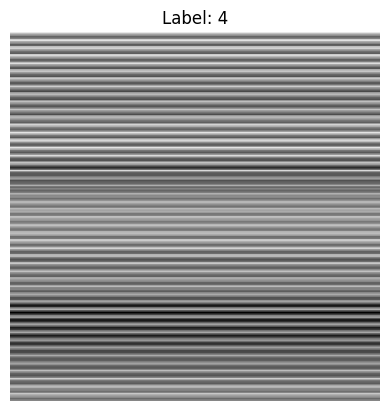

In [22]:
# Ambil satu contoh dari train_dataset
image, label = test_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [ ]:
image, label = train_dataset[0]
image.shape

## Build Vision Transformer (ViT) Model

In [ ]:
from torch import nn

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        # Jika labels diberikan, hitung loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
    
        return (loss, logits) if loss is not None else logits

## Model Training

In [ ]:
model = ViT(num_classes=len(class_names), in_channels=1, patch_size=32, num_heads=8, embedding_dim=512)

In [ ]:
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 1, 224, 224),  # (batch_size, in_channels, img_size, img_size)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

In [ ]:
EPOCHS = 100
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define path
SAVE_PATH = "../Hasil Eksperimen"
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best metric for model saving
best_val_accuracy = -float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{train_loss / (batch_idx + 1):.4f}",
            "Acc": f"{correct / total:.4f}"
        })

    # Calculate training accuracy and loss
    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Print training summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions for F1-score
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                "Acc": f"{val_correct / val_total:.4f}"
            })

    # Calculate validation accuracy, loss, and F1-score
    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_predicted, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Step the learning rate scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = os.path.join(SAVE_PATH, "aug_off_model.pt")
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

    # Save loss and accuracy plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(SAVE_PATH, "aug_off_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    accuracy_plot_path = os.path.join(SAVE_PATH, "aug_off_acc.png")
    plt.savefig(accuracy_plot_path)
    plt.close()